# Arctic Sea Ice Sonification


#### This script is meant to illustrate one way of transforming climata data -- in this case, the index of Arctic Sea ice - into a sonification. 
#### It uses the library Pyknon to create midi files: http://kroger.github.io/pyknon/


In [15]:
import pandas as pd
import numpy as np
from pyknon.genmidi import Midi
from pyknon.music import NoteSeq, Note, Rest
import sys
#sys.path.append('/Users/judytwedt/Documents/PyKnon/sonification-sandbox/')
#from data_mapping import *
from IPython.display import Image
#plotting package
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
sns.set_style("darkgrid")
cmap = sns.cubehelix_palette(n_colors = 40, start = .5, rot = -.75, hue = 1)
sns.set_palette(cmap)

In [3]:
from music21 import *
def playMidi(filename):
    # make a gui to play the midi file in the jupyter notebook
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')

### First we'll generate all notes on the piano keyboard, to get a sense of Pyknon 

In [13]:
# Pyknon dubs C5 as the value 0, so Note(0) give you C5
# (C in the 5th octave).  So we have to move 51 keys to the
# left to get the far left key on a piano.
first_note = Note("A,,,,,") # The far-left key on the piano

def note_from_key_number(k):
    return Note(k - 51)

piano_notes = list(map(note_from_key_number, range(88)))
print(("All piano notes:", piano_notes))

('All piano notes:', [<A>, <A#>, <B>, <C>, <C#>, <D>, <D#>, <E>, <F>, <F#>, <G>, <G#>, <A>, <A#>, <B>, <C>, <C#>, <D>, <D#>, <E>, <F>, <F#>, <G>, <G#>, <A>, <A#>, <B>, <C>, <C#>, <D>, <D#>, <E>, <F>, <F#>, <G>, <G#>, <A>, <A#>, <B>, <C>, <C#>, <D>, <D#>, <E>, <F>, <F#>, <G>, <G#>, <A>, <A#>, <B>, <C>, <C#>, <D>, <D#>, <E>, <F>, <F#>, <G>, <G#>, <A>, <A#>, <B>, <C>, <C#>, <D>, <D#>, <E>, <F>, <F#>, <G>, <G#>, <A>, <A#>, <B>, <C>, <C#>, <D>, <D#>, <E>, <F>, <F#>, <G>, <G#>, <A>, <A#>, <B>, <C>])


In [14]:
# Write this to a midi file for listening
mymidi = Midi(1, tempo=80)
mymidi.seq_notes(piano_notes, track=0)
mymidi.write("piano_keys.midi")
playMidi("piano_keys.midi")

In [6]:
def key_number(n):
    return n.octave * 12 + n.value - first_note.value

middle_c = Note("C,")     # key_number=39
note_nums = list(map(key_number, piano_notes))
print(("All Pyknon note values:", note_nums))
print(("Middle C key number:", key_number(middle_c)))

('All Pyknon note values:', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87])
('Middle C key number:', 39)


### Next, let's sonify a data set

In [7]:
#Load the sea ice dataset from National Snow and Ice Data center: https://nsidc.org/data/seaice_index/archives.html
xlsFile = pd.ExcelFile('Sea_Ice_Index_Monthly_Data_by_Year_G02135_v2.1.xlsx' )
xlsFile.sheet_names

['NH-Extent', 'NH-Area', 'SH-Extent', 'SH-Area', 'Documentation']

In [8]:
#extract Arctic sea ice data
NH = xlsFile.parse('NH-Extent')
nh_array = NH.iloc[1:,0:12].values.flatten() # continuous array of monthly values
nh_min = np.asarray(NH.iloc[1:,8]) # Sept
nyrs = int(len(nh_array)/12)

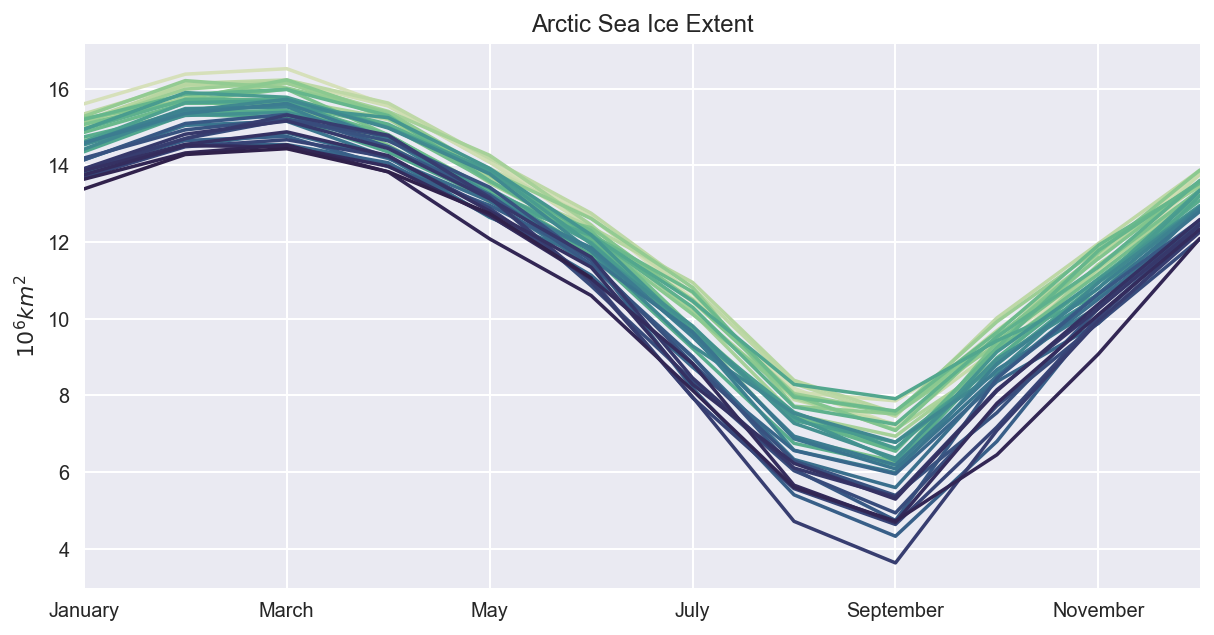

In [17]:
#View the data
nh0 = NH.iloc[1:, :12]
nh0.T.plot(legend = False)
plt.title("Arctic Sea Ice Extent")
plt.ylabel('$10^6 km ^2$')
plt.show()
# Shows the annual cycle, with later years in darker colors. 
# Sea ice loss is most evident in September, at the end of the summer melt period. 
# If you sonify this, you hear mostly the annual cycle.

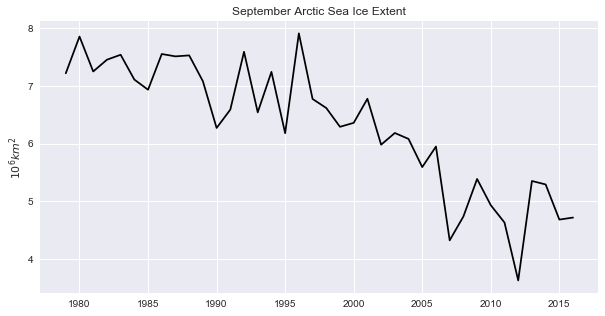

In [10]:
plt.plot(NH.iloc[1:,8], color = 'k')
plt.title('September Arctic Sea Ice Extent')
plt.ylabel('$10^6 km ^2$')
plt.show()
# Use this time series to modify the volume, with the annualVolume function. 

#### Each note object can be defined by value, octave, duration, and volume

#### Write some functions to map data to music notes

In [ ]:
def map_to_range(data, noctaves, ntones, lowestOctave):
        ''' map data to the specified number of octaves and tones per octave, starting
        on the lowestOctave.The tones will be the first n tones of the chromatic scale''' 
        nbins = noctaves*ntones - 1
        offset = data - np.nanmin(data)
        mapped = offset * nbins / np.nanmax(offset)
        octave = np.floor(mapped/ntones) + lowestOctave
        tone = np.floor(mapped%ntones)
        return octave, tone

In [ ]:
def convert_scale(notes, key = 0, scale = 'major'):
        if scale == 'major':
                 newscale = np.asarray([0, 2, 4, 5, 7, 9, 11]) + key
        elif scale == 'harm_minor':     
                newscale = np.asarray([0,2,3,5,7,8,11]) + key
        elif scale == 'nat_minor':
                newscale = np.asarray([0,2,3,5,7,8,10]) + key
        elif scale == 'wholetone':
                newscale = np.asarray([0,2,4,6,8,10]) + key     
        # optional write-in
        else:
                newscale = scale + key  
        notes_in_key = np.full(len(notes), np.nan)
        tones = np.unique(notes[~np.isnan(notes)])
        i = 0
        for tone in tones:
                notes_in_key[notes == tone] = newscale[i]
                i+=1
        return notes_in_key  

In [ ]:
def NoteSeqWithNaN(notes, octaves,  noteLength = 1/8, *volAdjust ):
    ''' create a note sequence, with missing data treated as a rest'''
    noteSequence  = []
    for i in range(len(notes)):
        if np.isnan(notes[i]):
            noteSequence.append(Rest(noteLength))
        else: 
            if volAdjust:
                noteSequence.append(Note(notes[i], octaves[i], noteLength, volAdjust[0][i]))
            else: 
                noteSequence.append(Note(notes[i], octaves[i], noteLength))
    return noteSequence

In [18]:
def sonify(x, nOcts = 2,ntones = 11, baseOct = 3):
    # map data set to n octaves with n tones per octave
    # nans are converted to rests
    octs,notes = map_to_range(x,nOcts, ntones,baseOct)
    return NoteSeqWithNaN(notes, nOcts)

In [19]:
def annualVolume(vols, nyrs):
    #vols is an annual array of values that will be mapped to monthly volumes
    #map to the volume range 50:110. Midi range is 0:127
    vols = vols - np.nanmin(vols)
    newVols = vols/np.nanmax(vols)*60. + 50.
    monVols = np.ravel(np.ones([12,nyrs])*newVols, order = 'F')
    monVols[np.isnan(monVols)] = 0
    return monVols

In [20]:
#Create the note Sequence for monthly values, mapping ice extent to pitch
octaves, tones = map_to_range(nh_array,5,7,3)
#shift to a harmonic minor scale
nh_notes = convert_scale(tones, scale = 'harm_minor')
#set sound level for each hear
nh_volumes = annualVolume(nh_min, nyrs)
#construc the note sequence. Missing data is a musical rest. 
nh_noteSeq = NoteSeqWithNaN(nh_notes, octaves, 1/16, nh_volumes)# volume each year modified by min. ice extent


In [21]:
iceSound_NH  = Midi(tempo = 120)
iceSound_NH.seq_notes(nh_noteSeq)
iceSound_NH.write('NH_iceExtentMonthly.midi')
playMidi('NH_iceExtentMonthly.midi') 